# 导入需要的库函数

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.nn import init
from torch import nn
import torchvision  
import torchvision.transforms as transforms 
import copy

# 定义需要的工具函数

In [4]:
def Draw_Curve(*args,xlabel = "epoch",ylabel = "loss"):
  for i in args:
    x = np.linspace(0,len(i[0]),len(i[0]))
    plt.plot(x,i[0],label=i[1],linewidth=1.5)  
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

def evaluate_accuracy(data_iter,net,loss_func):
  acc_sum,n,test_l_sum,c= 0.0,0,0.0,0
  for X,y in data_iter:
    acc_sum += (net(X).argmax(dim = 1) == y).sum().item()
    l = loss_func(net(X),y)
    test_l_sum += l.sum().item()
    c += 1
    n += y.shape[0]
  return acc_sum/n,test_l_sum/c


# 数据集生成

## 生成回归数据集

In [5]:
#设置维度500，训练集7000，测试集3000
num_inputs_regression = 500
num_train_regression = 7000
num_test_regression = 3000
#生成回归函数
true_w_regression = torch.ones(num_inputs_regression,1)*0.0056
true_b_regression = 0.028
#生成数据
features_regression = torch.randn((num_train_regression+num_test_regression,num_inputs_regression))
labels_regression = torch.matmul(features_regression,true_w_regression)+true_b_regression
labels_regression += torch.tensor(np.random.normal(0,0.01,size=labels_regression.size()),dtype = torch.float)
train_features_regression,test_features_regression = features_regression[:num_train_regression,:],features_regression[num_train_regression:,:]
train_labels_regression,test_labels_regression = labels_regression[:num_train_regression],labels_regression[num_train_regression:]

## 生成二分类数据集

In [6]:
#设置维度200，每一类10000个数据，训练集7000，测试集3000，服从均值互为相反数且方差相同的正态分布
num_inputs_binary = 200
num_train_binary = 7000
num_test_binary = 3000

#生成标签为0的数据
features_binary_0 = torch.normal(-3,1,(num_train_binary+num_test_binary,num_inputs_binary),dtype = torch.float)
labels_binary_0 = torch.zeros(10000,1)
#标签为0的数据集划分
train_features_binary_0 = features_binary_0[:num_train_binary]
train_labels_binary_0 = labels_binary_0[:num_train_binary]
test_features_binary_0 = features_binary_0[num_train_binary:]
test_labels_binary_0 = labels_binary_0[num_train_binary:]

#生成标签为1的数据
features_binary_1 = torch.normal(3,1,(num_train_binary+num_test_binary,num_inputs_binary),dtype = torch.float)
labels_binary_1 = torch.ones(10000,1)
#标签为0的数据集划分
train_features_binary_1 = features_binary_1[:num_train_binary]
train_labels_binary_1 = labels_binary_1[:num_train_binary]
test_features_binary_1 = features_binary_1[num_train_binary:]
test_labels_binary_1 = labels_binary_1[num_train_binary:]
#合并数据
train_features_binary = torch.cat((train_features_binary_0,train_features_binary_1),0)
train_labels_binary = torch.cat((train_labels_binary_0,train_labels_binary_1),0)
test_features_binary = torch.cat((test_features_binary_0,test_features_binary_1),0)
test_labels_binary = torch.cat((test_labels_binary_0,test_labels_binary_1),0)
print(train_features_binary.shape,train_labels_binary.shape,test_features_binary.shape,test_labels_binary.shape)


torch.Size([14000, 200]) torch.Size([14000, 1]) torch.Size([6000, 200]) torch.Size([6000, 1])


## 下载MNIST数据集

In [7]:
mnist_train = torchvision.datasets.MNIST(root='/content/sample_data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='/content/sample_data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/sample_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/sample_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/sample_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/sample_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/sample_data/MNIST/raw



# 手动实现回归

## 数据加载

In [8]:
batch_size = 64
dataset = Data.TensorDataset(train_features_regression, train_labels_regression)
train_reg_iter = Data.DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=0,)
dataset = Data.TensorDataset(test_features_regression, test_labels_regression)
test_reg_iter = Data.DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=0,)

## 参数初始化

In [9]:
num_outputs_regression,num_hiddens_regression = 1,128

W1 = torch.tensor(np.random.normal(0,0.01,(num_hiddens_regression,num_inputs_regression)),dtype = torch.float)
b1 = torch.zeros(1,dtype = torch.float)
W2 = torch.tensor(np.random.normal(0,0.01,(num_outputs_regression,num_hiddens_regression)),dtype = torch.float)
b2 = torch.zeros(1,dtype = torch.float)

params = [W1,b1,W2,b2]

for param in params:
  param.requires_grad_(requires_grad = True)

## 定义损失函数和优化器

In [10]:
# def squared_loss(y_hat,y):
#   return (y_hat-y.view(y_hat.size()))**2/2
loss = torch.nn.MSELoss()
def SGD(paras,lr,batch_size):
  for param in params:
    param.data -= lr * param.grad/batch_size

## 定义激活函数和网络模型

In [11]:
def relu(x):
  x = torch.max(input=x,other=torch.tensor(0.0))
  return x

def net_reg(X):
  X = X.view((-1,num_inputs_regression))
  H = relu(torch.matmul(X,W1.t())+b1)
  return torch.matmul(H,W2.t())+b2

## 定义训练函数

In [12]:
#定义模型训练函数
def train_reg(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
  train_loss,train_acc = [],[]
  test_loss,test_acc = [],[]
  for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    train_l_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
    #在每一个迭代周期中，会使用训练数据集中所有样本一次
    for X, y in train_iter: # x和y分别是小批量样本的特征和标签
      y_hat = net(X)
      l = loss(y_hat, y.view(-1,1)) # l是有关小批量X和y的损失
      l.backward() # 小批量的损失对模型参数求梯度
      optimizer(params,lr,batch_size)
      for param in params:
        param.grad.data.zero_()
      train_l_sum += l.item()
      # train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      # n += y.shape[0]
      c += 1
    # print(train_l_sum,train_acc_sum)
    # train_loss.append(train_l_sum/c)
    # train_acc.append(train_acc_sum/n)
    # test_acce,test_losse = evaluate_accuracy(test_iter,net,loss)
    # test_loss.append(test_losse)
    # test_acc.append(test_acce)
    train_labels = train_labels_regression.view(-1,1)
    test_labels = test_labels_regression.view(-1,1)
    #detach().numpy()待转换类型的PyTorch Tensor变量带有梯度，直接将其转换为numpy数据将破坏计算图，
    #因此numpy拒绝进行数据转换，实际上这是对开发者的一种提醒。如果自己在转换数据时不需要保留梯度信息，可以在变量转换之前添加detach()调用。
    train_loss.append(loss(net(train_features_regression),train_labels).detach().numpy())
    test_loss.append(loss(net(test_features_regression),test_labels).detach().numpy())
    print('epoch %d, train_loss %.4f, test_loss %.4f'%(epoch+1,train_loss[epoch],test_loss[epoch]))
  return train_loss,test_loss


## 运行训练

In [13]:
lr = 0.01
num_epochs = 20
train_loss_reg,test_loss_reg = train_reg(net_reg,train_reg_iter,test_reg_iter,loss,num_epochs,batch_size,params,lr,SGD)


epoch 1, train_loss 0.0173, test_loss 0.0173
epoch 2, train_loss 0.0172, test_loss 0.0172
epoch 3, train_loss 0.0171, test_loss 0.0171
epoch 4, train_loss 0.0170, test_loss 0.0171
epoch 5, train_loss 0.0170, test_loss 0.0170
epoch 6, train_loss 0.0169, test_loss 0.0169
epoch 7, train_loss 0.0168, test_loss 0.0169
epoch 8, train_loss 0.0168, test_loss 0.0168
epoch 9, train_loss 0.0167, test_loss 0.0168
epoch 10, train_loss 0.0167, test_loss 0.0168
epoch 11, train_loss 0.0167, test_loss 0.0167
epoch 12, train_loss 0.0166, test_loss 0.0167
epoch 13, train_loss 0.0166, test_loss 0.0167
epoch 14, train_loss 0.0166, test_loss 0.0166
epoch 15, train_loss 0.0166, test_loss 0.0166
epoch 16, train_loss 0.0165, test_loss 0.0166
epoch 17, train_loss 0.0165, test_loss 0.0166
epoch 18, train_loss 0.0165, test_loss 0.0166
epoch 19, train_loss 0.0165, test_loss 0.0166
epoch 20, train_loss 0.0165, test_loss 0.0165


## 绘制loss曲线

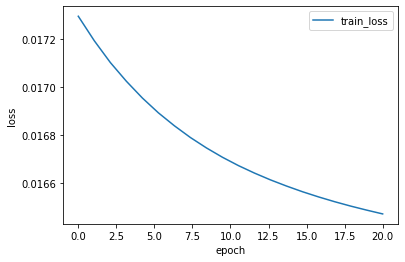

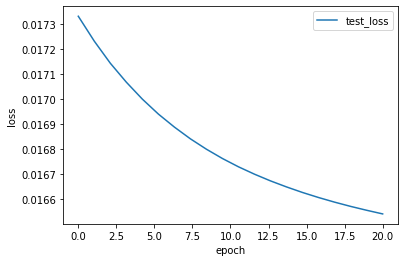

In [15]:
# print(train_loss_reg)
Draw_Curve([train_loss_reg,"train_loss"],ylabel = "loss")
Draw_Curve([test_loss_reg,"test_loss"],ylabel = "loss")

# 手动实现二分类

## 数据加载

In [16]:
batch_size = 128
train_binary_dataset = Data.TensorDataset(train_features_binary,train_labels_binary)
train_binary_iter = Data.DataLoader(dataset = train_binary_dataset,batch_size = batch_size,shuffle = True)

test_binary_dataset = Data.TensorDataset(test_features_binary,test_labels_binary)
test_binary_iter = Data.DataLoader(dataset = test_binary_dataset,batch_size = batch_size,shuffle = True)

## 参数初始化

In [24]:
num_outputs_binary,num_hiddens_binary = 1,128

W1 = torch.tensor(np.random.normal(0,0.01,(num_hiddens_binary,num_inputs_binary)),dtype = torch.float)
b1 = torch.zeros(1,dtype = torch.float)
W2 = torch.tensor(np.random.normal(0,0.01,(num_outputs_binary,num_hiddens_binary)),dtype = torch.float)
b2 = torch.zeros(1,dtype = torch.float)

params = [W1,b1,W2,b2]

for param in params:
  param.requires_grad_(requires_grad = True)

## 定义损失函数等参数
其他参数如激活函数、网络模型、优化器均采用回归时使用的参数

In [25]:
loss = torch.nn.BCEWithLogitsLoss()
def net_bin(X):
  X = X.view((-1,num_inputs_binary))
  H = relu(torch.matmul(X,W1.t())+b1)
  return torch.matmul(H,W2.t())+b2

## 定义训练函数

In [26]:
#定义模型训练函数
def train_bin(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
  train_loss,train_acc = [],[]
  test_loss,test_acc = [],[]
  for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    train_l_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
    #在每一个迭代周期中，会使用训练数据集中所有样本一次
    for X, y in train_iter: # x和y分别是小批量样本的特征和标签
      y_hat = net(X)
      l = loss(y_hat, y.view(-1,1)) # l是有关小批量X和y的损失
      l.backward() # 小批量的损失对模型参数求梯度
      optimizer(params,lr,batch_size)
      for param in params:
        param.grad.data.zero_()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      n += y.shape[0]
      c += 1
    # print(train_l_sum,train_acc_sum)
    train_labels = train_labels_binary.view(-1,1)
    test_labels = test_labels_binary.view(-1,1)
    #detach().numpy()待转换类型的PyTorch Tensor变量带有梯度，直接将其转换为numpy数据将破坏计算图，
    #因此numpy拒绝进行数据转换，实际上这是对开发者的一种提醒。如果自己在转换数据时不需要保留梯度信息，可以在变量转换之前添加detach()调用。
    # train_loss.append(train_l_sum/c)
    # train_acc.append(train_acc_sum/n)
    # test_acce,test_losse = evaluate_accuracy(test_iter,net,loss)
    # test_loss.append(test_losse)
    # test_acc.append(test_acce)
    train_loss.append(loss(net(train_features_binary),train_labels).detach().numpy())
    test_loss.append(loss(net(test_features_binary),test_labels).detach().numpy())
    print('epoch %d, train_loss %.4f, test_loss %.4f'%(epoch+1,train_loss[epoch],test_loss[epoch]))
  return train_loss,test_loss

## 训练

In [27]:
lr = 0.01
num_epochs = 30
train_loss_bin,test_loss_bin = train_bin(net_bin,train_binary_iter,test_binary_iter,loss,num_epochs,batch_size,params,lr,SGD)

epoch 1, train_loss 0.6627, test_loss 0.6626
epoch 2, train_loss 0.6408, test_loss 0.6407
epoch 3, train_loss 0.6183, test_loss 0.6182
epoch 4, train_loss 0.5949, test_loss 0.5949
epoch 5, train_loss 0.5704, test_loss 0.5703
epoch 6, train_loss 0.5445, test_loss 0.5445
epoch 7, train_loss 0.5173, test_loss 0.5172
epoch 8, train_loss 0.4888, test_loss 0.4887
epoch 9, train_loss 0.4593, test_loss 0.4592
epoch 10, train_loss 0.4291, test_loss 0.4291
epoch 11, train_loss 0.3987, test_loss 0.3987
epoch 12, train_loss 0.3686, test_loss 0.3686
epoch 13, train_loss 0.3392, test_loss 0.3392
epoch 14, train_loss 0.3109, test_loss 0.3109
epoch 15, train_loss 0.2842, test_loss 0.2842
epoch 16, train_loss 0.2591, test_loss 0.2591
epoch 17, train_loss 0.2360, test_loss 0.2360
epoch 18, train_loss 0.2149, test_loss 0.2149
epoch 19, train_loss 0.1957, test_loss 0.1957
epoch 20, train_loss 0.1784, test_loss 0.1784
epoch 21, train_loss 0.1628, test_loss 0.1628
epoch 22, train_loss 0.1489, test_loss 0.14

## 绘制loss曲线

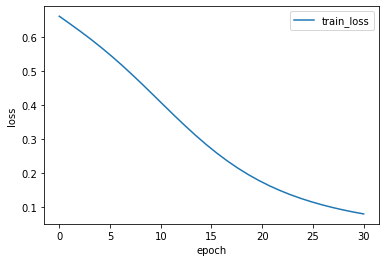

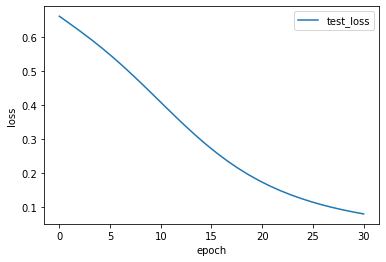

In [28]:
# print(train_loss_reg)
Draw_Curve([train_loss_bin,"train_loss"],ylabel = "loss")
Draw_Curve([test_loss_bin,"test_loss"],ylabel = "loss")

# 手动实现手写数字

## 数据加载

In [29]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=0)  
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

## 参数初始化

In [30]:
num_inputs_mnist,num_outputs_mnist,num_hiddens_mnist = 28*28,10,128

W1 = torch.tensor(np.random.normal(0,0.01,(num_hiddens_mnist,num_inputs_mnist)),dtype = torch.float)
b1 = torch.zeros(1,dtype = torch.float)
W2 = torch.tensor(np.random.normal(0,0.01,(num_outputs_mnist,num_hiddens_mnist)),dtype = torch.float)
b2 = torch.zeros(1,dtype = torch.float)

params = [W1,b1,W2,b2]

for param in params:
  param.requires_grad_(requires_grad = True)

## 定义损失函数等参数
其他参数如激活函数、网络模型、优化器均采用回归时使用的参数

In [31]:
loss = torch.nn.CrossEntropyLoss()
def net_mnist(X):
  X = X.view((-1,num_inputs_mnist))
  H = relu(torch.matmul(X,W1.t())+b1)
  return torch.matmul(H,W2.t())+b2
def mySGD(paras,lr):
  for param in params:
    param.data -= lr * param.grad

## 定义训练函数

In [32]:
def train_mnist(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
  train_loss,train_acc = [],[]
  test_loss,test_acc = [],[]
  for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    train_l_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
  # 在每一个迭代周期中，会使用训练数据集中所有样本一次
    for X, y in train_iter: # x和y分别是小批量样本的特征和标签
      y_hat = net(X)
      l = loss(y_hat, y).sum() # l是有关小批量X和y的损失
      #梯度清零
      if optimizer is not None:
        optimizer.zero_grad()
      elif params is not None and params[0].grad is not None:
        for param in params:
          param.grad.data.zero_()
      l.backward()# 小批量的损失对模型参数求梯度
      if optimizer is None:
        mySGD(params,lr)
      else:
        optimizer.step()
      #计算每个epoch的loss
      train_l_sum += l.item()*y.shape[0]
    #计算训练样本的准确率
      train_acc_sum += (y_hat.argmax(dim=1)==y).sum().item()
    #每一个epoch的所有样本数
      n+= y.shape[0]
    train_loss.append(train_l_sum/n)
    train_acc.append(train_acc_sum/n)
    test_acce,test_losse = evaluate_accuracy(test_iter,net,loss)
    test_loss.append(test_losse)
    test_acc.append(test_acce)
    print('epoch %d, train_loss %.6f,test_loss %f,train_acc %.6f,test_acc %.6f'%(epoch+1, train_loss[epoch],test_loss[epoch],train_acc_sum/n,test_acce))
  return train_loss,test_loss

## 训练

In [33]:
lr = 0.01
num_epochs = 20
train_loss_mnist,test_loss_mnist = train_mnist(net_mnist,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)

epoch 1, train_loss 1.760408,test_loss 0.890876,train_acc 0.616900,test_acc 0.796300
epoch 2, train_loss 0.641365,test_loss 0.479484,train_acc 0.840433,test_acc 0.873900
epoch 3, train_loss 0.443301,test_loss 0.385041,train_acc 0.880283,test_acc 0.892800
epoch 4, train_loss 0.382538,test_loss 0.347719,train_acc 0.893200,test_acc 0.902300
epoch 5, train_loss 0.352068,test_loss 0.325223,train_acc 0.900200,test_acc 0.907000
epoch 6, train_loss 0.332468,test_loss 0.309508,train_acc 0.905683,test_acc 0.911300
epoch 7, train_loss 0.318174,test_loss 0.298158,train_acc 0.908683,test_acc 0.913900
epoch 8, train_loss 0.306179,test_loss 0.289462,train_acc 0.912300,test_acc 0.916600
epoch 9, train_loss 0.295600,test_loss 0.280647,train_acc 0.915333,test_acc 0.921800
epoch 10, train_loss 0.286336,test_loss 0.271464,train_acc 0.918267,test_acc 0.923800
epoch 11, train_loss 0.277620,test_loss 0.264444,train_acc 0.920450,test_acc 0.925500
epoch 12, train_loss 0.269202,test_loss 0.257643,train_acc 0.92

## 绘制loss曲线

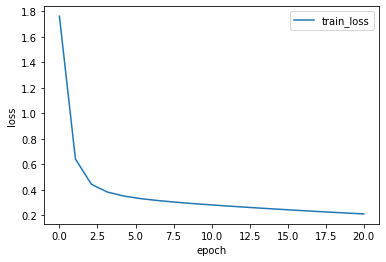

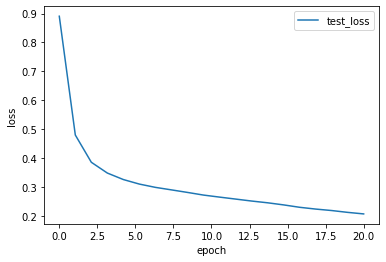

In [34]:
# print(train_loss_reg)
Draw_Curve([train_loss_mnist,"train_loss"],ylabel = "loss")
Draw_Curve([test_loss_mnist,"test_loss"],ylabel = "loss")

# torch.nn实现回归网络

## 参数初始化和网络实现

In [35]:
class Net_reg_nn(nn.Module):
  def __init__(self):
    super(Net_reg_nn,self).__init__()
    #定义输入输出和隐藏层的神经元数量
    num_inputs_reg_nn,num_hiddens_reg_nn,num_outputs_reg_nn = 500,128,1
    #定义模型结构
    self.input_layer = lambda x: x.view(x.shape[0],-1)
    self.hidden_layer = nn.Sequential(
      nn.Linear(num_inputs_reg_nn,num_hiddens_reg_nn),
      nn.ReLU()
    )
    self.output_layer = nn.Linear(num_hiddens_reg_nn,num_outputs_reg_nn)
    #初始化参数
    for h_param in self.hidden_layer.parameters():
      torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
    for o_param in self.output_layer.parameters():
      torch.nn.init.normal_(o_param,mean = 0,std = 0.01)
  #定义模型前向传播过程
  def forward(self,x):
    flatten_input = self.input_layer(x)
    hidden_output = self.hidden_layer(flatten_input)
    final_output = self.output_layer(hidden_output)
    return final_output


## 定义训练函数

In [38]:
def train_reg_nn(net, train_iter, loss_func, num_epoch, lr, optimizer):
  train_loss_list,train_acc_list,test_loss_list,test_acc_list = [],[],[],[]
  for epoch in range(num_epoch):
    train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss_func(y_hat,y)
      #梯度清理
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      n += y.shape[0]
      c += 1
    test_acc,test_loss = evaluate_accuracy(test_reg_iter,net,loss_func)
    train_loss_list.append(train_l_sum/c)
    train_acc_list.append(train_acc_sum/n)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print('epoch %d, train loss %.4f, test loss %.4f'%(epoch+1, train_l_sum/c, test_loss))
    # print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, test acc %.3f'
    # %(epoch+1, train_l_sum/c, train_acc_sum/n, test_loss,test_acc))
  return train_loss_list,test_loss_list

## 训练模型

In [39]:
net = Net_reg_nn()
num_epochs = 20
lr = 0.01
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_reg_loss_nn,test_reg_loss_nn=train_reg_nn(net,train_reg_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 0.0166, test loss 0.0162
epoch 2, train loss 0.0159, test loss 0.0157
epoch 3, train loss 0.0154, test loss 0.0153
epoch 4, train loss 0.0149, test loss 0.0148
epoch 5, train loss 0.0143, test loss 0.0143
epoch 6, train loss 0.0137, test loss 0.0137
epoch 7, train loss 0.0129, test loss 0.0129
epoch 8, train loss 0.0121, test loss 0.0121
epoch 9, train loss 0.0111, test loss 0.0112
epoch 10, train loss 0.0100, test loss 0.0102
epoch 11, train loss 0.0089, test loss 0.0091
epoch 12, train loss 0.0078, test loss 0.0080
epoch 13, train loss 0.0066, test loss 0.0069
epoch 14, train loss 0.0056, test loss 0.0060
epoch 15, train loss 0.0046, test loss 0.0051
epoch 16, train loss 0.0038, test loss 0.0043
epoch 17, train loss 0.0032, test loss 0.0037
epoch 18, train loss 0.0026, test loss 0.0032
epoch 19, train loss 0.0022, test loss 0.0028
epoch 20, train loss 0.0019, test loss 0.0025


## 绘制loss曲线

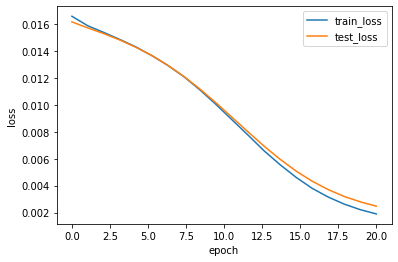

In [40]:
Draw_Curve([train_reg_loss_nn,"train_loss"],[test_reg_loss_nn,"test_loss"],ylabel = "loss")

# torch.nn实现二分类

## 参数初始化和网络实现

In [41]:
class Net_bin_nn(nn.Module):
  def __init__(self):
    super(Net_bin_nn,self).__init__()
    #定义输入输出和隐藏层的神经元数量
    num_inputs_bin_nn,num_hiddens_bin_nn,num_outputs_bin_nn = 200,128,1
    #定义模型结构
    self.input_layer = lambda x: x.view(x.shape[0],-1)
    self.hidden_layer = nn.Sequential(
      nn.Linear(num_inputs_bin_nn,num_hiddens_bin_nn),
      nn.ReLU()
    )
    self.output_layer = nn.Linear(num_hiddens_bin_nn,num_outputs_bin_nn)
    #初始化参数
    for h_param in self.hidden_layer.parameters():
      torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
    for o_param in self.output_layer.parameters():
      torch.nn.init.normal_(o_param,mean = 0,std = 0.01)
  #定义模型前向传播过程
  def forward(self,x):
    flatten_input = self.input_layer(x)
    hidden_output = self.hidden_layer(flatten_input)
    final_output = self.output_layer(hidden_output)
    return final_output



## 定义训练函数

In [42]:
def train_bin_nn(net, train_iter, loss_func, num_epoch, lr, optimizer):
  train_loss_list,train_acc_list,test_loss_list,test_acc_list = [],[],[],[]
  for epoch in range(num_epoch):
    train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss_func(y_hat,y.view(-1,1))
      #梯度清理
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      n += y.shape[0]
      c += 1
    test_acc,test_loss = evaluate_accuracy(test_binary_iter,net,loss_func)
    train_loss_list.append(train_l_sum/c)
    train_acc_list.append(train_acc_sum/n)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print('epoch %d, train loss %.4f, test loss %.4f'%(epoch+1, train_l_sum/c, test_loss))
    # print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, test acc %.3f'
    # %(epoch+1, train_l_sum/c, train_acc_sum/n, test_loss,test_acc))
  return train_loss_list,test_loss_list

## 训练模型

In [45]:
net = Net_bin_nn()
num_epochs = 20
lr = 0.01
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_bin_loss_nn,test_bin_loss_nn=train_bin_nn(net,train_binary_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 0.0941, test loss 0.0063
epoch 2, train loss 0.0038, test loss 0.0024
epoch 3, train loss 0.0018, test loss 0.0014
epoch 4, train loss 0.0012, test loss 0.0010
epoch 5, train loss 0.0008, test loss 0.0007
epoch 6, train loss 0.0007, test loss 0.0006
epoch 7, train loss 0.0005, test loss 0.0005
epoch 8, train loss 0.0005, test loss 0.0004
epoch 9, train loss 0.0004, test loss 0.0004
epoch 10, train loss 0.0003, test loss 0.0003
epoch 11, train loss 0.0003, test loss 0.0003
epoch 12, train loss 0.0003, test loss 0.0003
epoch 13, train loss 0.0002, test loss 0.0002
epoch 14, train loss 0.0002, test loss 0.0002
epoch 15, train loss 0.0002, test loss 0.0002
epoch 16, train loss 0.0002, test loss 0.0002
epoch 17, train loss 0.0002, test loss 0.0002
epoch 18, train loss 0.0002, test loss 0.0002
epoch 19, train loss 0.0002, test loss 0.0002
epoch 20, train loss 0.0001, test loss 0.0001


## 绘制loss曲线

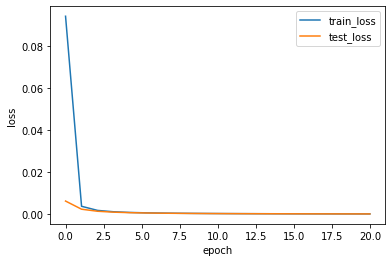

In [46]:
Draw_Curve([train_bin_loss_nn,"train_loss"],[test_bin_loss_nn,"test_loss"],ylabel = "loss")

# torch.nn实现MNIST

## 参数初始化和网络实现

In [47]:
class Net_mnist_nn(nn.Module):
  def __init__(self):
    super(Net_mnist_nn,self).__init__()
    #定义输入输出和隐藏层的神经元数量
    num_inputs_mnist_nn,num_hiddens_mnist_nn,num_outputs_mnist_nn = 28*28,64,10
    #定义模型结构
    self.input_layer = lambda x: x.view(x.shape[0],-1)
    self.hidden_layer = nn.Sequential(
      nn.Linear(num_inputs_mnist_nn,num_hiddens_mnist_nn),
      nn.ReLU()
      # nn.Tanh()
      # nn.LeakyReLU()

    )
    # self.hidden_layer2 = nn.Sequential(
    #   nn.Linear(num_hiddens_mnist_nn,num_hiddens_mnist_nn),
    #   nn.ReLU()
    #   # nn.Tanh()
    #   # nn.LeakyReLU()

    # )
    # self.hidden_layer3 = nn.Sequential(
    #   nn.Linear(num_hiddens_mnist_nn,num_hiddens_mnist_nn),
    #   nn.ReLU()
    #   # nn.Tanh()
    #   # nn.LeakyReLU()

    # )
    self.output_layer = nn.Linear(num_hiddens_mnist_nn,num_outputs_mnist_nn)
    #初始化参数
    for h_param in self.hidden_layer.parameters():
      torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
    # for h_param in self.hidden_layer2.parameters():
    #   torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
    # for h_param in self.hidden_layer3.parameters():
    #   torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
    for o_param in self.output_layer.parameters():
      torch.nn.init.normal_(o_param,mean = 0,std = 0.01)
  #定义模型前向传播过程
  def forward(self,x):
    flatten_input = self.input_layer(x)
    hidden_output = self.hidden_layer(flatten_input)
    # hidden3_hidden2 = self.hidden_layer2(hidden_hidden2)
    # hidden3_output = self.hidden_layer3(hidden3_hidden2)
    final_output = self.output_layer(hidden_output)
    return final_output

## 定义训练函数

In [49]:
def train_mnist_nn(net, train_iter, loss_func, num_epoch, lr, optimizer):
  train_loss_list,train_acc_list,test_loss_list,test_acc_list = [],[],[],[]
  for epoch in range(num_epoch):
    train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss_func(y_hat,y)
      #梯度清理
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      n += y.shape[0]
      c += 1
    # print('正确的数量为：%d'%train_acc_sum)
    test_acc,test_loss = evaluate_accuracy(test_iter,net,loss_func)
    train_loss_list.append(train_l_sum/c)
    train_acc_list.append(train_acc_sum/n)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    # print('epoch %d, train loss %.4f, test loss %.4f'%(epoch+1, train_l_sum/n, test_loss))
    print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, test acc %.3f'
    %(epoch+1, train_l_sum/c, train_acc_sum/n, test_loss,test_acc))
  return train_loss_list,test_loss_list

## 训练模型

In [55]:
net = Net_mnist_nn()
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn,test_mnist_loss_nn=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 1.9824, train acc 0.437, test loss 1.1664, test acc 0.735
epoch 2, train loss 0.7780, train acc 0.806, test loss 0.5483, test acc 0.859
epoch 3, train loss 0.4922, train acc 0.870, test loss 0.4188, test acc 0.888
epoch 4, train loss 0.4080, train acc 0.889, test loss 0.3663, test acc 0.898
epoch 5, train loss 0.3684, train acc 0.897, test loss 0.3388, test acc 0.904
epoch 6, train loss 0.3443, train acc 0.903, test loss 0.3190, test acc 0.909
epoch 7, train loss 0.3276, train acc 0.907, test loss 0.3065, test acc 0.912
epoch 8, train loss 0.3144, train acc 0.910, test loss 0.2958, test acc 0.914
epoch 9, train loss 0.3037, train acc 0.913, test loss 0.2865, test acc 0.919
epoch 10, train loss 0.2939, train acc 0.916, test loss 0.2791, test acc 0.921


## 绘制loss曲线

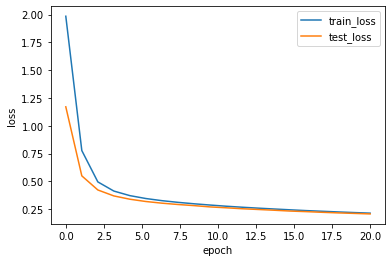

In [51]:
Draw_Curve([train_mnist_loss_nn,"train_loss"],[test_mnist_loss_nn,"test_loss"],ylabel = "loss")

# 更改激活函数

In [52]:
#tanh
net = Net_mnist_nn()
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_tanh,test_mnist_loss_nn_tanh=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 2.2526, train acc 0.317, test loss 2.1094, test acc 0.431
epoch 2, train loss 1.6422, train acc 0.624, test loss 1.1272, test acc 0.752
epoch 3, train loss 0.8911, train acc 0.785, test loss 0.6949, test acc 0.827
epoch 4, train loss 0.6281, train acc 0.838, test loss 0.5406, test acc 0.857
epoch 5, train loss 0.5188, train acc 0.863, test loss 0.4634, test acc 0.876
epoch 6, train loss 0.4594, train acc 0.877, test loss 0.4189, test acc 0.886
epoch 7, train loss 0.4217, train acc 0.885, test loss 0.3898, test acc 0.889
epoch 8, train loss 0.3960, train acc 0.891, test loss 0.3674, test acc 0.898
epoch 9, train loss 0.3769, train acc 0.896, test loss 0.3518, test acc 0.900
epoch 10, train loss 0.3622, train acc 0.899, test loss 0.3391, test acc 0.903


In [53]:
#LeakyReLu
net = Net_mnist_nn()
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_LR,test_mnist_loss_nn_LR=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 2.2546, train acc 0.317, test loss 2.1134, test acc 0.397
epoch 2, train loss 1.6564, train acc 0.592, test loss 1.1546, test acc 0.715
epoch 3, train loss 0.9174, train acc 0.772, test loss 0.7191, test acc 0.818
epoch 4, train loss 0.6453, train acc 0.831, test loss 0.5546, test acc 0.852
epoch 5, train loss 0.5290, train acc 0.859, test loss 0.4729, test acc 0.872
epoch 6, train loss 0.4649, train acc 0.875, test loss 0.4242, test acc 0.884
epoch 7, train loss 0.4245, train acc 0.884, test loss 0.3908, test acc 0.892
epoch 8, train loss 0.3966, train acc 0.891, test loss 0.3678, test acc 0.896
epoch 9, train loss 0.3761, train acc 0.896, test loss 0.3508, test acc 0.900
epoch 10, train loss 0.3602, train acc 0.900, test loss 0.3381, test acc 0.904


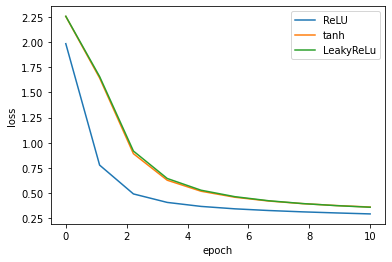

In [56]:
Draw_Curve([train_mnist_loss_nn,"ReLU"],[train_mnist_loss_nn_tanh,"tanh"],[train_mnist_loss_nn_LR,"LeakyReLu"],ylabel = "loss")

# 更改隐藏神经元数量

In [ ]:
#256
net = Net_mnist_nn()
num_epochs = 10
lr = 0.005
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_256,test_mnist_loss_nn_256=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

正确的数量为：34802
epoch 1, train loss 2.1550, train acc 0.580, test loss 1.7988, test acc 0.692
正确的数量为：44772
epoch 2, train loss 1.2599, train acc 0.746, test loss 0.8490, test acc 0.811
正确的数量为：49840
epoch 3, train loss 0.7117, train acc 0.831, test loss 0.5810, test acc 0.856
正确的数量为：51771
epoch 4, train loss 0.5414, train acc 0.863, test loss 0.4738, test acc 0.878
正确的数量为：52711
epoch 5, train loss 0.4631, train acc 0.879, test loss 0.4180, test acc 0.890
正确的数量为：53238
epoch 6, train loss 0.4185, train acc 0.887, test loss 0.3848, test acc 0.896
正确的数量为：53596
epoch 7, train loss 0.3898, train acc 0.893, test loss 0.3610, test acc 0.899
正确的数量为：53844
epoch 8, train loss 0.3695, train acc 0.897, test loss 0.3450, test acc 0.903
正确的数量为：54042
epoch 9, train loss 0.3542, train acc 0.901, test loss 0.3321, test acc 0.904
正确的数量为：54218
epoch 10, train loss 0.3419, train acc 0.904, test loss 0.3216, test acc 0.907


In [ ]:
#64
net = Net_mnist_nn()
num_epochs = 10
lr = 0.005
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_64,test_mnist_loss_nn_64=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

正确的数量为：20439
epoch 1, train loss 2.2603, train acc 0.341, test loss 2.1354, test acc 0.435
正确的数量为：37537
epoch 2, train loss 1.6891, train acc 0.626, test loss 1.1660, test acc 0.747
正确的数量为：47151
epoch 3, train loss 0.9093, train acc 0.786, test loss 0.7025, test acc 0.825
正确的数量为：50412
epoch 4, train loss 0.6296, train acc 0.840, test loss 0.5382, test acc 0.862
正确的数量为：51947
epoch 5, train loss 0.5151, train acc 0.866, test loss 0.4591, test acc 0.880
正确的数量为：52742
epoch 6, train loss 0.4537, train acc 0.879, test loss 0.4134, test acc 0.889
正确的数量为：53226
epoch 7, train loss 0.4161, train acc 0.887, test loss 0.3841, test acc 0.893
正确的数量为：53539
epoch 8, train loss 0.3905, train acc 0.892, test loss 0.3618, test acc 0.898
正确的数量为：53810
epoch 9, train loss 0.3718, train acc 0.897, test loss 0.3480, test acc 0.902
正确的数量为：53986
epoch 10, train loss 0.3568, train acc 0.900, test loss 0.3352, test acc 0.906


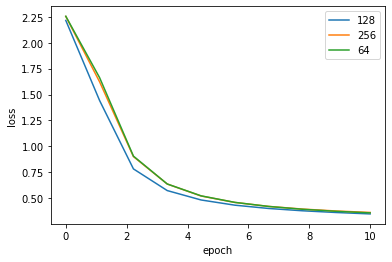

In [ ]:
Draw_Curve([train_mnist_loss_nn,"128"],[train_mnist_loss_nn_256,"256"],[train_mnist_loss_nn_64,"64"],ylabel = "loss")

# 更改隐藏层数

In [ ]:
#2层，每一层64个神经元
net = Net_mnist_nn()
num_epochs = 10
lr = 0.005
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_2,test_mnist_loss_nn_2=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

正确的数量为：6766
epoch 1, train loss 2.3019, train acc 0.113, test loss 2.3014, test acc 0.114
正确的数量为：6742
epoch 2, train loss 2.3012, train acc 0.112, test loss 2.3008, test acc 0.114
正确的数量为：6742
epoch 3, train loss 2.3007, train acc 0.112, test loss 2.3003, test acc 0.114
正确的数量为：6742
epoch 4, train loss 2.3001, train acc 0.112, test loss 2.2995, test acc 0.114
正确的数量为：6742
epoch 5, train loss 2.2988, train acc 0.112, test loss 2.2973, test acc 0.114
正确的数量为：7335
epoch 6, train loss 2.2939, train acc 0.122, test loss 2.2867, test acc 0.178
正确的数量为：12326
epoch 7, train loss 2.2517, train acc 0.205, test loss 2.1728, test acc 0.209
正确的数量为：13389
epoch 8, train loss 2.0546, train acc 0.223, test loss 1.9150, test acc 0.274
正确的数量为：19004
epoch 9, train loss 1.7656, train acc 0.317, test loss 1.6373, test acc 0.368
正确的数量为：24863
epoch 10, train loss 1.5767, train acc 0.414, test loss 1.4911, test acc 0.481


In [ ]:
#3层，每一层64个神经元
net = Net_mnist_nn()
num_epochs = 10
lr = 0.005
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_3,test_mnist_loss_nn_3=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

正确的数量为：6255
epoch 1, train loss 2.3024, train acc 0.104, test loss 2.3018, test acc 0.114
正确的数量为：6742
epoch 2, train loss 2.3016, train acc 0.112, test loss 2.3014, test acc 0.114
正确的数量为：6742
epoch 3, train loss 2.3014, train acc 0.112, test loss 2.3012, test acc 0.114
正确的数量为：6742
epoch 4, train loss 2.3012, train acc 0.112, test loss 2.3011, test acc 0.114
正确的数量为：6742
epoch 5, train loss 2.3012, train acc 0.112, test loss 2.3011, test acc 0.114
正确的数量为：6742
epoch 6, train loss 2.3012, train acc 0.112, test loss 2.3010, test acc 0.114
正确的数量为：6742
epoch 7, train loss 2.3012, train acc 0.112, test loss 2.3010, test acc 0.114
正确的数量为：6742
epoch 8, train loss 2.3012, train acc 0.112, test loss 2.3010, test acc 0.114
正确的数量为：6742
epoch 9, train loss 2.3012, train acc 0.112, test loss 2.3010, test acc 0.114
正确的数量为：6742
epoch 10, train loss 2.3012, train acc 0.112, test loss 2.3010, test acc 0.114


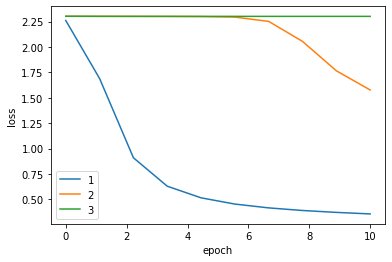

In [ ]:
Draw_Curve([train_mnist_loss_nn_64,"1"],[train_mnist_loss_nn_2,"2"],[train_mnist_loss_nn_3,"3"],ylabel = "loss")

# 实现dropout

## 手动实现dropout

In [ ]:
def dropout(X,drop_prob):
  X = X.float()
  assert 0 <= drop_prob <= 1
  keep_prob = 1 - drop_prob
  if keep_prob == 0:
    return torch.zeros_like(X)
  mask = (torch.rand(X.shape) < keep_prob).float()
  return mask * X / keep_prob

In [ ]:
num_inputs_mnist,num_outputs_mnist,num_hiddens_mnist = 28*28,10,128

W1 = torch.tensor(np.random.normal(0,0.01,(num_hiddens_mnist,num_inputs_mnist)),dtype = torch.float)
b1 = torch.zeros(1,dtype = torch.float)
W2 = torch.tensor(np.random.normal(0,0.01,(num_outputs_mnist,num_hiddens_mnist)),dtype = torch.float)
b2 = torch.zeros(1,dtype = torch.float)

params = [W1,b1,W2,b2]

for param in params:
  param.requires_grad_(requires_grad = True)

In [ ]:
drop_prob1 = 0.1
drop_prob2 = 0.2
drop_prob3 = 0.5

def net_drop(X, is_training=True):
  X = X.view(-1, num_inputs_mnist)
  H1 = (torch.matmul(X, W1.t()) + b1).relu()
  if is_training:
    H1 = dropout(H1, drop_prob3)     #修改丢弃率
  return (torch.matmul(H1,W2.t()) + b2).relu()

In [ ]:
def evaluate_accuracy_drop(data_iter,net,loss_func):
  acc_sum,n,test_l_sum,c= 0.0,0,0.0,0
  for X,y in data_iter:
    acc_sum += (net(X,is_training=False).argmax(dim = 1) == y).sum().item()
    l = loss_func(net(X),y)
    test_l_sum += l.sum().item()
    c += 1
    n += y.shape[0]
  return acc_sum/n,test_l_sum/c

In [ ]:
def train_mnist_nn(net, train_iter, loss_func, num_epoch, lr, optimizer):
  train_loss_list,train_acc_list,test_loss_list,test_acc_list = [],[],[],[]
  for epoch in range(num_epoch):
    train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss_func(y_hat,y)
      #梯度清理
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      n += y.shape[0]
      c += 1
    test_acc,test_loss = evaluate_accuracy_drop(test_iter,net,loss_func)
    train_loss_list.append(train_l_sum/c)
    train_acc_list.append(train_acc_sum/n)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    # print('epoch %d, train loss %.4f, test loss %.4f'%(epoch+1, train_l_sum/n, test_loss))
    print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, test acc %.3f'
    %(epoch+1, train_l_sum/c, train_acc_sum/n, test_loss,test_acc))
  return train_loss_list,test_loss_list

In [ ]:
#0.1丢弃率
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W1,b1,W2,b2],lr)
train_mnist_loss_nn_drop,test_mnist_loss_nn_drop=train_mnist_nn(net_drop,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 1.8325, train acc 0.544, test loss 0.9695, test acc 0.787
epoch 2, train loss 0.6955, train acc 0.819, test loss 0.5240, test acc 0.869
epoch 3, train loss 0.4817, train acc 0.866, test loss 0.4185, test acc 0.894
epoch 4, train loss 0.4124, train acc 0.883, test loss 0.3770, test acc 0.900
epoch 5, train loss 0.3753, train acc 0.892, test loss 0.3463, test acc 0.906
epoch 6, train loss 0.3510, train acc 0.899, test loss 0.3292, test acc 0.911
epoch 7, train loss 0.3314, train acc 0.904, test loss 0.3111, test acc 0.916
epoch 8, train loss 0.3166, train acc 0.908, test loss 0.3011, test acc 0.919
epoch 9, train loss 0.3018, train acc 0.913, test loss 0.2874, test acc 0.921
epoch 10, train loss 0.2884, train acc 0.917, test loss 0.2745, test acc 0.925


In [ ]:
#0.2丢弃率
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W1,b1,W2,b2],lr)
train_mnist_loss_nn_drop2,test_mnist_loss_nn_drop2=train_mnist_nn(net_drop,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 1.8305, train acc 0.566, test loss 0.9902, test acc 0.795
epoch 2, train loss 0.7162, train acc 0.811, test loss 0.5453, test acc 0.873
epoch 3, train loss 0.4976, train acc 0.862, test loss 0.4364, test acc 0.892
epoch 4, train loss 0.4262, train acc 0.879, test loss 0.3861, test acc 0.903
epoch 5, train loss 0.3845, train acc 0.891, test loss 0.3571, test acc 0.909
epoch 6, train loss 0.3598, train acc 0.897, test loss 0.3374, test acc 0.913
epoch 7, train loss 0.3375, train acc 0.903, test loss 0.3148, test acc 0.918
epoch 8, train loss 0.3195, train acc 0.908, test loss 0.3047, test acc 0.920
epoch 9, train loss 0.3046, train acc 0.913, test loss 0.2857, test acc 0.925
epoch 10, train loss 0.2919, train acc 0.916, test loss 0.2782, test acc 0.927


In [ ]:
#0.5丢弃率
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W1,b1,W2,b2],lr)
train_mnist_loss_nn_drop5,test_mnist_loss_nn_drop5=train_mnist_nn(net_drop,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 1.8829, train acc 0.486, test loss 1.1114, test acc 0.774
epoch 2, train loss 0.8322, train acc 0.763, test loss 0.6466, test acc 0.861
epoch 3, train loss 0.5889, train acc 0.831, test loss 0.5174, test acc 0.889
epoch 4, train loss 0.4976, train acc 0.858, test loss 0.4505, test acc 0.901
epoch 5, train loss 0.4473, train acc 0.872, test loss 0.4121, test acc 0.907
epoch 6, train loss 0.4116, train acc 0.882, test loss 0.3808, test acc 0.914
epoch 7, train loss 0.3856, train acc 0.890, test loss 0.3579, test acc 0.917
epoch 8, train loss 0.3634, train acc 0.895, test loss 0.3470, test acc 0.922
epoch 9, train loss 0.3476, train acc 0.900, test loss 0.3274, test acc 0.925
epoch 10, train loss 0.3356, train acc 0.904, test loss 0.3131, test acc 0.928


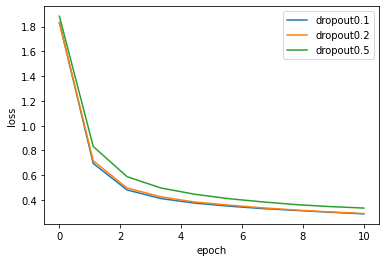

In [ ]:
Draw_Curve([train_mnist_loss_nn_drop,"dropout0.1"],[train_mnist_loss_nn_drop2,"dropout0.2"],[train_mnist_loss_nn_drop5,"dropout0.5"],ylabel = "loss")

## torch.nn实现dropout

In [ ]:
drop_prob1 = 0.1
drop_prob2 = 0.2
drop_prob3 = 0.5
class Net_mnist_nn(nn.Module):
  def __init__(self):
    super(Net_mnist_nn,self).__init__()
    #定义输入输出和隐藏层的神经元数量
    num_inputs_mnist_nn,num_hiddens_mnist_nn,num_outputs_mnist_nn = 28*28,64,10
    #定义模型结构
    self.input_layer = lambda x: x.view(x.shape[0],-1)
    self.hidden_layer = nn.Sequential(
      nn.Linear(num_inputs_mnist_nn,num_hiddens_mnist_nn),
      nn.ReLU()
    )
    self.dropout = nn.Dropout(drop_prob1)   #修改丢弃率
    self.output_layer = nn.Linear(num_hiddens_mnist_nn,num_outputs_mnist_nn)
    #初始化参数
    for h_param in self.hidden_layer.parameters():
      torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
    for o_param in self.output_layer.parameters():
      torch.nn.init.normal_(o_param,mean = 0,std = 0.01)
  #定义模型前向传播过程
  def forward(self,x):
    flatten_input = self.input_layer(x)
    hidden_drop = self.hidden_layer(flatten_input)
    drop_output = self.dropout(hidden_drop)
    final_output = self.output_layer(drop_output)
    return final_output

In [ ]:
def evaluate_accuracy_dropn(data_iter,net,loss_func):
  acc_sum,n,test_l_sum,c= 0.0,0,0.0,0
  for X,y in data_iter:
    if isinstance(net,torch.nn.Module):
      net.eval()
      acc_sum += (net(X).argmax(dim = 1) == y).sum().item()
      l = loss_func(net(X),y)
      test_l_sum += l.sum().item()
      net.train()
    c += 1
    n += y.shape[0]
  return acc_sum/n,test_l_sum/c

In [ ]:
def train_mnist_nn_dropn(net, train_iter, loss_func, num_epoch, lr, optimizer):
  train_loss_list,train_acc_list,test_loss_list,test_acc_list = [],[],[],[]
  for epoch in range(num_epoch):
    train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss_func(y_hat,y)
      #梯度清理
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      n += y.shape[0]
      c += 1
    test_acc,test_loss = evaluate_accuracy_dropn(test_iter,net,loss_func)
    train_loss_list.append(train_l_sum/c)
    train_acc_list.append(train_acc_sum/n)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    # print('epoch %d, train loss %.4f, test loss %.4f'%(epoch+1, train_l_sum/n, test_loss))
    print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, test acc %.3f'
    %(epoch+1, train_l_sum/c, train_acc_sum/n, test_loss,test_acc))
  return train_loss_list,test_loss_list

In [ ]:
#丢弃率0.1
net = Net_mnist_nn()
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_dropn1,test_mnist_loss_nn_dropn1=train_mnist_nn_dropn(net,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 1.9474, train acc 0.511, test loss 1.1270, test acc 0.757
epoch 2, train loss 0.8028, train acc 0.789, test loss 0.5495, test acc 0.862
epoch 3, train loss 0.5381, train acc 0.850, test loss 0.4263, test acc 0.889
epoch 4, train loss 0.4534, train acc 0.871, test loss 0.3732, test acc 0.897
epoch 5, train loss 0.4087, train acc 0.883, test loss 0.3424, test acc 0.905
epoch 6, train loss 0.3781, train acc 0.891, test loss 0.3219, test acc 0.910
epoch 7, train loss 0.3588, train acc 0.897, test loss 0.3048, test acc 0.915
epoch 8, train loss 0.3387, train acc 0.901, test loss 0.2908, test acc 0.917
epoch 9, train loss 0.3258, train acc 0.907, test loss 0.2784, test acc 0.922
epoch 10, train loss 0.3115, train acc 0.910, test loss 0.2686, test acc 0.924


In [ ]:
#丢弃率0.2
net = Net_mnist_nn()
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_dropn2,test_mnist_loss_nn_dropn2=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 2.0090, train acc 0.474, test loss 1.2192, test acc 0.735
epoch 2, train loss 0.8802, train acc 0.756, test loss 0.5739, test acc 0.857
epoch 3, train loss 0.5829, train acc 0.835, test loss 0.4350, test acc 0.887
epoch 4, train loss 0.4858, train acc 0.862, test loss 0.3775, test acc 0.897
epoch 5, train loss 0.4353, train acc 0.876, test loss 0.3452, test acc 0.903
epoch 6, train loss 0.3999, train acc 0.886, test loss 0.3224, test acc 0.910
epoch 7, train loss 0.3755, train acc 0.893, test loss 0.3051, test acc 0.915
epoch 8, train loss 0.3551, train acc 0.899, test loss 0.2907, test acc 0.918
epoch 9, train loss 0.3396, train acc 0.903, test loss 0.2782, test acc 0.922
epoch 10, train loss 0.3242, train acc 0.906, test loss 0.2678, test acc 0.925


In [ ]:
#丢弃率0.5
net = Net_mnist_nn()
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)
train_mnist_loss_nn_dropn3,test_mnist_loss_nn_dropn3=train_mnist_nn(net,train_iter,loss,num_epochs,lr,optimizer)

epoch 1, train loss 2.0122, train acc 0.438, test loss 1.2429, test acc 0.744
epoch 2, train loss 1.0104, train acc 0.697, test loss 0.6339, test acc 0.846
epoch 3, train loss 0.7257, train acc 0.784, test loss 0.4871, test acc 0.877
epoch 4, train loss 0.6163, train acc 0.820, test loss 0.4165, test acc 0.890
epoch 5, train loss 0.5546, train acc 0.841, test loss 0.3761, test acc 0.898
epoch 6, train loss 0.5109, train acc 0.853, test loss 0.3444, test acc 0.906
epoch 7, train loss 0.4820, train acc 0.861, test loss 0.3240, test acc 0.911
epoch 8, train loss 0.4561, train acc 0.871, test loss 0.3052, test acc 0.915
epoch 9, train loss 0.4378, train acc 0.874, test loss 0.2911, test acc 0.918
epoch 10, train loss 0.4177, train acc 0.881, test loss 0.2793, test acc 0.921


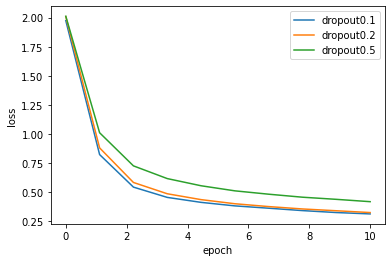

In [ ]:
Draw_Curve([train_mnist_loss_nn_dropn1,"dropout0.1"],[train_mnist_loss_nn_dropn2,"dropout0.2"],[train_mnist_loss_nn_dropn3,"dropout0.5"],ylabel = "loss")

# 实现L2正则化

## 手动实现L2正则化

In [ ]:
#定义L2范数
def l2_penalty(w):
  return (w**2).sum()/2

In [ ]:
#参数初始化
num_inputs_mnist,num_outputs_mnist,num_hiddens_mnist = 28*28,10,128
def init_params():
  W1 = torch.tensor(np.random.normal(0,0.01,(num_hiddens_mnist,num_inputs_mnist)),dtype = torch.float)
  b1 = torch.zeros(1,dtype = torch.float)
  W2 = torch.tensor(np.random.normal(0,0.01,(num_outputs_mnist,num_hiddens_mnist)),dtype = torch.float)
  b2 = torch.zeros(1,dtype = torch.float)
  params = [W1,b1,W2,b2]
  for param in params:
    param.requires_grad_(requires_grad = True)
  return W1,b1,W2,b2

In [ ]:
#定义模型
def relu(X):
  X = torch.max(input=X,other=torch.tensor(0.0))
  return X
def net_l2(X):
  X = X.view((-1,num_inputs_mnist))
  H = relu(torch.matmul(X,W1.t())+b1)
  return torch.matmul(H,W2.t())+b2

In [ ]:
#计算准确率
def evaluate_accuracy_l2(data_iter,net,loss_func,mylambda):
  acc_sum,n,test_l_sum,c= 0.0,0,0.0,0
  for X,y in data_iter:
    acc_sum += (net(X).argmax(dim = 1) == y).sum().item()
    l = loss_func(net(X),y) + mylambda * l2_penalty(W1) + mylambda * l2_penalty(W2)
    test_l_sum += l.sum().item()
    c += 1
    n += y.shape[0]
  return acc_sum/n,test_l_sum/c

In [ ]:
#定义训练函数
def train_mnist_l2(net, train_iter, loss_func, num_epoch, lr, optimizer, mylambda):
  train_loss_list,train_acc_list,test_loss_list,test_acc_list = [],[],[],[]
  
  for epoch in range(num_epoch):
    train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss_func(y_hat,y) + mylambda * l2_penalty(W1) + mylambda * l2_penalty(W2)
      #梯度清理
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      n += y.shape[0]
      c += 1
    test_acc,test_loss = evaluate_accuracy_l2(test_iter,net,loss_func,mylambda)
    train_loss_list.append(train_l_sum/c)
    train_acc_list.append(train_acc_sum/n)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    # print('epoch %d, train loss %.4f, test loss %.4f'%(epoch+1, train_l_sum/n, test_loss))
    print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, test acc %.3f'
    %(epoch+1, train_l_sum/c, train_acc_sum/n, test_loss,test_acc))
  return train_loss_list,test_loss_list

In [ ]:
# lambda = 1
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
W1,b1,W2,b2 = init_params()
optimizer = torch.optim.SGD([W1,b1,W2,b2],lr)
train_mnist_loss_l2_1,test_mnist_loss_l2_1=train_mnist_l2(net_l2,train_iter,loss,num_epochs,lr,optimizer,1)

epoch 1, train loss 2.5756, train acc 0.171, test loss 2.3026, test acc 0.114
epoch 2, train loss 2.3026, train acc 0.112, test loss 2.3026, test acc 0.114
epoch 3, train loss 2.3026, train acc 0.112, test loss 2.3025, test acc 0.114
epoch 4, train loss 2.3025, train acc 0.112, test loss 2.3025, test acc 0.114
epoch 5, train loss 2.3025, train acc 0.112, test loss 2.3024, test acc 0.114
epoch 6, train loss 2.3024, train acc 0.112, test loss 2.3023, test acc 0.114
epoch 7, train loss 2.3024, train acc 0.112, test loss 2.3022, test acc 0.114
epoch 8, train loss 2.3023, train acc 0.112, test loss 2.3022, test acc 0.114
epoch 9, train loss 2.3022, train acc 0.112, test loss 2.3020, test acc 0.114
epoch 10, train loss 2.3022, train acc 0.112, test loss 2.3019, test acc 0.114


In [ ]:
# lambda = 0.1
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
W1,b1,W2,b2 = init_params()
optimizer = torch.optim.SGD([W1,b1,W2,b2],lr)
train_mnist_loss_l2_5,test_mnist_loss_l2_5=train_mnist_l2(net_l2,train_iter,loss,num_epochs,lr,optimizer,0.1)

epoch 1, train loss 2.2980, train acc 0.528, test loss 1.7119, test acc 0.678
epoch 2, train loss 1.5615, train acc 0.763, test loss 1.4690, test acc 0.809
epoch 3, train loss 1.4693, train acc 0.818, test loss 1.4390, test acc 0.826
epoch 4, train loss 1.4558, train acc 0.833, test loss 1.4318, test acc 0.844
epoch 5, train loss 1.4529, train acc 0.838, test loss 1.4329, test acc 0.840
epoch 6, train loss 1.4517, train acc 0.842, test loss 1.4298, test acc 0.845
epoch 7, train loss 1.4514, train acc 0.843, test loss 1.4320, test acc 0.846
epoch 8, train loss 1.4512, train acc 0.844, test loss 1.4302, test acc 0.853
epoch 9, train loss 1.4510, train acc 0.845, test loss 1.4288, test acc 0.859
epoch 10, train loss 1.4510, train acc 0.846, test loss 1.4309, test acc 0.852


In [ ]:
# lambda = 0.5
num_epochs = 10
lr = 0.01
W1,b1,W2,b2 = init_params()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W1,b1,W2,b2],lr)
train_mnist_loss_l2_2,test_mnist_loss_l2_2=train_mnist_l2(net_l2,train_iter,loss,num_epochs,lr,optimizer,0.5)

epoch 1, train loss 2.5727, train acc 0.274, test loss 2.3021, test acc 0.235
epoch 2, train loss 2.3013, train acc 0.204, test loss 2.3000, test acc 0.193
epoch 3, train loss 2.2996, train acc 0.191, test loss 2.2978, test acc 0.203
epoch 4, train loss 2.2979, train acc 0.203, test loss 2.2960, test acc 0.214
epoch 5, train loss 2.2969, train acc 0.210, test loss 2.2945, test acc 0.211
epoch 6, train loss 2.2965, train acc 0.216, test loss 2.2942, test acc 0.208
epoch 7, train loss 2.2965, train acc 0.214, test loss 2.2945, test acc 0.222
epoch 8, train loss 2.2965, train acc 0.217, test loss 2.2940, test acc 0.210
epoch 9, train loss 2.2965, train acc 0.214, test loss 2.2940, test acc 0.209
epoch 10, train loss 2.2965, train acc 0.215, test loss 2.2941, test acc 0.210


In [ ]:
# lambda = 0.3
num_epochs = 10
lr = 0.01
W1,b1,W2,b2 = init_params()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W1,b1,W2,b2],lr)
train_mnist_loss_l2_3,test_mnist_loss_l2_3=train_mnist_l2(net_l2,train_iter,loss,num_epochs,lr,optimizer,0.3)

epoch 1, train loss 2.5531, train acc 0.371, test loss 2.2417, test acc 0.356
epoch 2, train loss 2.1872, train acc 0.424, test loss 2.1454, test acc 0.508
epoch 3, train loss 2.1504, train acc 0.521, test loss 2.1371, test acc 0.565
epoch 4, train loss 2.1469, train acc 0.542, test loss 2.1351, test acc 0.576
epoch 5, train loss 2.1465, train acc 0.546, test loss 2.1351, test acc 0.549
epoch 6, train loss 2.1463, train acc 0.547, test loss 2.1358, test acc 0.546
epoch 7, train loss 2.1463, train acc 0.547, test loss 2.1342, test acc 0.543
epoch 8, train loss 2.1465, train acc 0.547, test loss 2.1348, test acc 0.566
epoch 9, train loss 2.1464, train acc 0.549, test loss 2.1356, test acc 0.521
epoch 10, train loss 2.1464, train acc 0.547, test loss 2.1347, test acc 0.551


In [ ]:
# lambda = 0
num_epochs = 10
lr = 0.01
W1,b1,W2,b2 = init_params()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W1,b1,W2,b2],lr)
train_mnist_loss_l2_0,test_mnist_loss_l2_0=train_mnist_l2(net_l2,train_iter,loss,num_epochs,lr,optimizer,0)

epoch 1, train loss 1.7617, train acc 0.579, test loss 0.8839, test acc 0.811
epoch 2, train loss 0.6374, train acc 0.842, test loss 0.4768, test acc 0.875
epoch 3, train loss 0.4444, train acc 0.881, test loss 0.3877, test acc 0.893
epoch 4, train loss 0.3837, train acc 0.893, test loss 0.3498, test acc 0.902
epoch 5, train loss 0.3532, train acc 0.900, test loss 0.3299, test acc 0.907
epoch 6, train loss 0.3339, train acc 0.905, test loss 0.3123, test acc 0.911
epoch 7, train loss 0.3195, train acc 0.909, test loss 0.2994, test acc 0.915
epoch 8, train loss 0.3082, train acc 0.912, test loss 0.2930, test acc 0.918
epoch 9, train loss 0.2982, train acc 0.915, test loss 0.2838, test acc 0.920
epoch 10, train loss 0.2897, train acc 0.917, test loss 0.2747, test acc 0.922


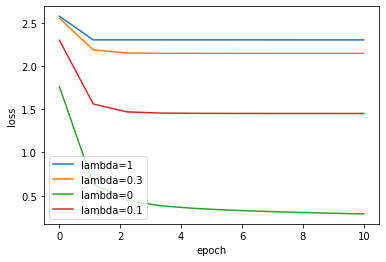

In [ ]:
Draw_Curve([train_mnist_loss_l2_1,"lambda=1"],[train_mnist_loss_l2_3,"lambda=0.3"],[train_mnist_loss_l2_0,"lambda=0"],[train_mnist_loss_l2_5,"lambda=0.1"],ylabel = "loss")

## torch.nn实现L2正则化

In [ ]:
# 定义网络
num_inputs_mnist,num_outputs_mnist,num_hiddens_mnist = 28*28,10,128
class Net_mnist_l2(nn.Module):
  def __init__(self):
    super(Net_mnist_l2,self).__init__()
    #定义输入输出和隐藏层的神经元数量
    num_inputs_mnist_nn,num_hiddens_mnist_nn,num_outputs_mnist_nn = 28*28,128,10
    #定义模型结构
    self.input_layer = lambda x: x.view(x.shape[0],-1)
    self.hidden_layer = nn.Sequential(
      nn.Linear(num_inputs_mnist_nn,num_hiddens_mnist_nn),
      nn.ReLU()
      # nn.Tanh()
      # nn.LeakyReLU()

    )
    self.output_layer = nn.Linear(num_hiddens_mnist_nn,num_outputs_mnist_nn)
    #初始化参数
    for h_param in self.hidden_layer.parameters():
      torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
    for o_param in self.output_layer.parameters():
      torch.nn.init.normal_(o_param,mean = 0,std = 0.01)
  #定义模型前向传播过程
  def forward(self,x):
    flatten_input = self.input_layer(x)
    hidden_output = self.hidden_layer(flatten_input)
    final_output = self.output_layer(hidden_output)
    return final_output

In [ ]:
def train_mnist_nn_l2(net, train_iter, loss_func, num_epoch, lr, lambd):
  train_loss_list,train_acc_list,test_loss_list,test_acc_list = [],[],[],[]
  optimizer_w = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=lambd)
  for epoch in range(num_epoch):
    train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss_func(y_hat,y)
      #梯度清理
      optimizer_w.zero_grad()
      l.backward()
      optimizer_w.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
      n += y.shape[0]
      c += 1
    test_acc,test_loss = evaluate_accuracy(test_iter,net,loss_func)
    train_loss_list.append(train_l_sum/c)
    train_acc_list.append(train_acc_sum/n)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    # print('epoch %d, train loss %.4f, test loss %.4f'%(epoch+1, train_l_sum/n, test_loss))
    print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, test acc %.3f'
    %(epoch+1, train_l_sum/c, train_acc_sum/n, test_loss,test_acc))
  return train_loss_list,test_loss_list

In [ ]:
# lambda = 0.5
num_epochs = 10
net = Net_mnist_l2()
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
train_nn_loss_l2_5,test_nn_loss_l2_5=train_mnist_nn_l2(net,train_iter,loss,num_epochs,lr,0.5)

epoch 1, train loss 1.8435, train acc 0.574, test loss 1.0072, test acc 0.772
epoch 2, train loss 0.7208, train acc 0.828, test loss 0.5400, test acc 0.866
epoch 3, train loss 0.4995, train acc 0.874, test loss 0.4354, test acc 0.888
epoch 4, train loss 0.4320, train acc 0.889, test loss 0.3932, test acc 0.898
epoch 5, train loss 0.3997, train acc 0.896, test loss 0.3706, test acc 0.903
epoch 6, train loss 0.3810, train acc 0.900, test loss 0.3570, test acc 0.905
epoch 7, train loss 0.3688, train acc 0.903, test loss 0.3488, test acc 0.911
epoch 8, train loss 0.3595, train acc 0.906, test loss 0.3391, test acc 0.910
epoch 9, train loss 0.3523, train acc 0.908, test loss 0.3338, test acc 0.914
epoch 10, train loss 0.3463, train acc 0.910, test loss 0.3293, test acc 0.914


In [ ]:
# lambda = 0.1
num_epochs = 10
net = Net_mnist_l2()
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
train_nn_loss_l2_01,test_nn_loss_l2_01=train_mnist_nn_l2(net,train_iter,loss,num_epochs,lr,0.1)

epoch 1, train loss 1.8657, train acc 0.568, test loss 1.0325, test acc 0.780
epoch 2, train loss 0.7323, train acc 0.824, test loss 0.5461, test acc 0.864
epoch 3, train loss 0.5037, train acc 0.872, test loss 0.4407, test acc 0.884
epoch 4, train loss 0.4342, train acc 0.888, test loss 0.3957, test acc 0.897
epoch 5, train loss 0.4008, train acc 0.895, test loss 0.3717, test acc 0.902
epoch 6, train loss 0.3807, train acc 0.900, test loss 0.3577, test acc 0.906
epoch 7, train loss 0.3673, train acc 0.904, test loss 0.3462, test acc 0.908
epoch 8, train loss 0.3571, train acc 0.906, test loss 0.3377, test acc 0.912
epoch 9, train loss 0.3489, train acc 0.909, test loss 0.3306, test acc 0.914
epoch 10, train loss 0.3426, train acc 0.912, test loss 0.3250, test acc 0.916


In [ ]:
# lambda = 1
num_epochs = 10
net = Net_mnist_l2()
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
train_nn_loss_l2_1,test_nn_loss_l2_1=train_mnist_nn_l2(net,train_iter,loss,num_epochs,lr,1)

epoch 1, train loss 1.8588, train acc 0.584, test loss 1.0225, test acc 0.770
epoch 2, train loss 0.7303, train acc 0.824, test loss 0.5461, test acc 0.864
epoch 3, train loss 0.5033, train acc 0.873, test loss 0.4381, test acc 0.888
epoch 4, train loss 0.4336, train acc 0.888, test loss 0.3938, test acc 0.898
epoch 5, train loss 0.4006, train acc 0.895, test loss 0.3710, test acc 0.902
epoch 6, train loss 0.3811, train acc 0.900, test loss 0.3567, test acc 0.906
epoch 7, train loss 0.3682, train acc 0.903, test loss 0.3464, test acc 0.909
epoch 8, train loss 0.3593, train acc 0.906, test loss 0.3379, test acc 0.912
epoch 9, train loss 0.3516, train acc 0.909, test loss 0.3336, test acc 0.913
epoch 10, train loss 0.3456, train acc 0.910, test loss 0.3296, test acc 0.916


In [ ]:
# lambda = 0
num_epochs = 10
net = Net_mnist_l2()
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
train_nn_loss_l2_0,test_nn_loss_l2_0=train_mnist_nn_l2(net,train_iter,loss,num_epochs,lr,0)

epoch 1, train loss 1.8913, train acc 0.545, test loss 1.0467, test acc 0.777
epoch 2, train loss 0.7338, train acc 0.824, test loss 0.5437, test acc 0.864
epoch 3, train loss 0.5032, train acc 0.872, test loss 0.4386, test acc 0.887
epoch 4, train loss 0.4349, train acc 0.888, test loss 0.3952, test acc 0.897
epoch 5, train loss 0.4020, train acc 0.896, test loss 0.3720, test acc 0.902
epoch 6, train loss 0.3828, train acc 0.900, test loss 0.3581, test acc 0.905
epoch 7, train loss 0.3704, train acc 0.903, test loss 0.3487, test acc 0.909
epoch 8, train loss 0.3612, train acc 0.906, test loss 0.3403, test acc 0.910
epoch 9, train loss 0.3538, train acc 0.908, test loss 0.3348, test acc 0.913
epoch 10, train loss 0.3478, train acc 0.910, test loss 0.3310, test acc 0.916


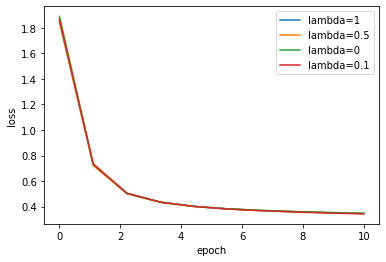

In [ ]:
Draw_Curve([train_nn_loss_l2_1,"lambda=1"],[train_nn_loss_l2_5,"lambda=0.5"],[train_nn_loss_l2_0,"lambda=0"],[train_nn_loss_l2_01,"lambda=0.1"],ylabel = "loss")

# K折交叉验证

## 回归

In [ ]:
def evaluate_accuracy(data_iter,net,loss_func):
    acc_sum,n,test_l_sum,c= 0.0,0,0.0,0
    for X,y in data_iter:
        acc_sum += (net(X).argmax(dim = 1) == y).sum().item()
        l = loss_func(net(X),y)
        test_l_sum += l.sum().item()
        c += 1
        n += y.shape[0]
    return acc_sum/n,test_l_sum/c
class Net_reg_nn(nn.Module):
    def __init__(self):
        super(Net_reg_nn,self).__init__()
        #定义输入输出和隐藏层的神经元数量
        num_inputs_reg_nn,num_hiddens_reg_nn,num_outputs_reg_nn = 500,128,1
        #定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0],-1)
        self.hidden_layer = nn.Sequential(
              nn.Linear(num_inputs_reg_nn,num_hiddens_reg_nn),
              nn.ReLU()
        )
        self.output_layer = nn.Linear(num_hiddens_reg_nn,num_outputs_reg_nn)
    #初始化参数
        for h_param in self.hidden_layer.parameters():
            torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
        for o_param in self.output_layer.parameters():
            torch.nn.init.normal_(o_param,mean = 0,std = 0.01)
  #定义模型前向传播过程
    def forward(self,x):
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        final_output = self.output_layer(hidden_output)
        return final_output

def get_kfold_data(k,i,X,y):
    fold_size = X.shape[0] // k
    print("yes")
    val_start = i * fold_size  
    if i != k - 1:
        val_end = (i + 1) * fold_size
        X_valid,y_valid=X[val_start:val_end],y[val_start:val_end]
        X_train=torch.cat((X[0:val_start],X[val_end:]),dim=0)
        y_train=torch.cat((y[0:val_start],y[val_end:]),dim=0)
    else:
        X_valid,y_valid=X[val_start:],y[val_start:]
        X_train=X[0:val_start]
        y_train=y[0:val_start]
    return X_train,y_train,X_valid,y_valid
def train_reg_k(net, train_data,train_label, valid_data,valid_label):
    train_iter = Data.DataLoader(
        dataset=Data.TensorDataset(train_data,train_label),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # 多线程来读数据，在Win下需要设置为0
  )
    valid_iter = Data.DataLoader(
        dataset=Data.TensorDataset(valid_data,valid_label),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
  )
    train_acc, train_l = 0.0, 0.0
    valid_acc, valid_l = 0.0, 0.0
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()
    for epoch in range(20):
        train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
        for X,y in train_iter:
            y_hat = net(X)
            l = loss_func(y_hat,y)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc,test_loss = evaluate_accuracy(valid_iter,net,loss_func)
        valid_acc += test_acc
        valid_l += test_loss
        train_acc += train_acc_sum/n
        train_l += train_l_sum/n
    return train_l/20,valid_l/20,train_acc/20,valid_acc/20
def kfold_train(k):
    train_loss_sum, valid_loss_sum = 0, 0
    train_acc_sum, valid_acc_sum = 0, 0
    for i in range(k):
        print('第', i+1, '折验证')
        train_data, train_label, valid_data, valid_label = get_kfold_data(k, i, train_features_regression,train_labels_regression)
        net = Net_reg_nn() 
        train_loss, val_loss, train_acc, val_acc = train_reg_k(net, train_data,train_label, valid_data,valid_label)
        print('train loss %.4f, val loss %.4f' % (train_loss, val_loss))
        train_loss_sum += train_loss
        valid_loss_sum += val_loss
        train_acc_sum += train_acc
        valid_acc_sum += val_acc
    print('\n最终k折交叉验证结果：')
    print('ave train loss: %.4f, ave valid loss: %.4f' % (train_loss_sum/k, valid_loss_sum/k))
  # print('ave valid loss: %.4f, ave valid acc: %.3f' % (valid_loss_sum/k, valid_acc_sum/k))

kfold_train(10)

第 1 折验证
yes
train loss 0.0002, val loss 0.0115
第 2 折验证
yes
train loss 0.0002, val loss 0.0100
第 3 折验证
yes
train loss 0.0002, val loss 0.0103
第 4 折验证
yes
train loss 0.0002, val loss 0.0101
第 5 折验证
yes
train loss 0.0002, val loss 0.0100
第 6 折验证
yes
train loss 0.0001, val loss 0.0099
第 7 折验证
yes
train loss 0.0002, val loss 0.0107
第 8 折验证
yes
train loss 0.0002, val loss 0.0106
第 9 折验证
yes
train loss 0.0002, val loss 0.0097
第 10 折验证
yes
train loss 0.0002, val loss 0.0091

最终k折交叉验证结果：
ave train loss: 0.0002, ave valid loss: 0.0102


## 二分类

In [ ]:
def evaluate_accuracy(data_iter,net,loss_func):
    acc_sum,n,test_l_sum,c= 0.0,0,0.0,0
    for X,y in data_iter:
        acc_sum += (net(X).argmax(dim = 1) == y).sum().item()
        l = loss_func(net(X),y)
        test_l_sum += l.sum().item()
        c += 1
        n += y.shape[0]
    return acc_sum/n,test_l_sum/c
class train_bin_nn(nn.Module):
    def __init__(self):
        super(train_bin_nn,self).__init__()
        #定义输入输出和隐藏层的神经元数量
        num_inputs_reg_nn,num_hiddens_reg_nn,num_outputs_reg_nn = 200,128,1
        #定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0],-1)
        self.hidden_layer = nn.Sequential(
              nn.Linear(num_inputs_reg_nn,num_hiddens_reg_nn),
              nn.ReLU()
        )
        self.output_layer = nn.Linear(num_hiddens_reg_nn,num_outputs_reg_nn)
    #初始化参数
        for h_param in self.hidden_layer.parameters():
            torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
        for o_param in self.output_layer.parameters():
            torch.nn.init.normal_(o_param,mean = 0,std = 0.01)
  #定义模型前向传播过程
    def forward(self,x):
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        final_output = self.output_layer(hidden_output)
        return final_output

def get_kfold_data(k,i,X,y):
    fold_size = X.shape[0] // k
    val_start = i * fold_size
    
    if i != k - 1:
        val_end = (i + 1) * fold_size
        X_valid,y_valid=X[val_start:val_end],y[val_start:val_end]
        X_train=torch.cat((X[0:val_start],X[val_end:]),dim=0)
        y_train=torch.cat((y[0:val_start],y[val_end:]),dim=0)
    else:
        X_valid,y_valid=X[val_start:],y[val_start:]
        X_train=X[0:val_start]
        y_train=y[0:val_start]
    return X_train,y_train,X_valid,y_valid
def train_reg_k(net, train_data,train_label, valid_data,valid_label):
    train_iter = Data.DataLoader(
        dataset=Data.TensorDataset(train_data,train_label),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # 多线程来读数据，在Win下需要设置为0
  )
    valid_iter = Data.DataLoader(
        dataset=Data.TensorDataset(valid_data,valid_label),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
  )
    train_acc, train_l = 0.0, 0.0
    valid_acc, valid_l = 0.0, 0.0
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()
    for epoch in range(20):
        train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
        for X,y in train_iter:
            y_hat = net(X)
            l = loss_func(y_hat,y)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc,test_loss = evaluate_accuracy(valid_iter,net,loss_func)
        valid_acc += test_acc
        valid_l += test_loss
        train_acc += train_acc_sum/n
        train_l += train_l_sum/n
    return train_l/20,valid_l/20,train_acc/20,valid_acc/20
def kfold_train(k):
    train_loss_sum, valid_loss_sum = 0, 0
    train_acc_sum, valid_acc_sum = 0, 0
    for i in range(k):
        print('第', i+1, '折验证')
        train_data, train_label, valid_data, valid_label = get_kfold_data(k, i, train_features_binary,train_labels_binary)
        net = train_bin_nn() 
        train_loss, val_loss, train_acc, val_acc = train_reg_k(net, train_data,train_label, valid_data,valid_label)
        print('train loss %f, val loss %f' % (train_loss, val_loss))
        train_loss_sum += train_loss
        valid_loss_sum += val_loss
        train_acc_sum += train_acc
        valid_acc_sum += val_acc
    print('\n最终k折交叉验证结果：')
    print('ave train loss: %f, ave valid loss: %f' % (train_loss_sum/k, valid_loss_sum/k))
  # print('ave valid loss: %.4f, ave valid acc: %.3f' % (valid_loss_sum/k, valid_acc_sum/k))

kfold_train(10)

第 1 折验证
train loss 0.000008, val loss 0.000083
第 2 折验证
train loss 0.000008, val loss 0.000109
第 3 折验证
train loss 0.000008, val loss 0.000080
第 4 折验证
train loss 0.000008, val loss 0.000111
第 5 折验证
train loss 0.000008, val loss 0.000100
第 6 折验证
train loss 0.000007, val loss 0.000831
第 7 折验证
train loss 0.000006, val loss 0.000763
第 8 折验证
train loss 0.000008, val loss 0.000879
第 9 折验证
train loss 0.000008, val loss 0.000815
第 10 折验证
train loss 0.000008, val loss 0.000841

最终k折交叉验证结果：
ave train loss: 0.000008, ave valid loss: 0.000461


## 手写数字

In [ ]:
def evaluate_accuracy_dropn(data_iter,net,loss_func):
  acc_sum,n,test_l_sum,c= 0.0,0,0.0,0
  for X,y in data_iter:
    if isinstance(net,torch.nn.Module):
      net.eval()
      acc_sum += (net(X).argmax(dim = 1) == y).sum().item()
      l = loss_func(net(X),y)
      test_l_sum += l.sum().item()
      net.train()
    c += 1
    n += y.shape[0]
  return acc_sum/n,test_l_sum/c

class Net_mnist_nn(nn.Module):
  def __init__(self):
    super(Net_mnist_nn,self).__init__()
    #定义输入输出和隐藏层的神经元数量
    num_inputs_mnist_nn,num_hiddens_mnist_nn,num_outputs_mnist_nn = 28*28,64,10
    #定义模型结构
    self.input_layer = lambda x: x.view(x.shape[0],-1)
    self.hidden_layer = nn.Sequential(
      nn.Linear(num_inputs_mnist_nn,num_hiddens_mnist_nn),
      nn.ReLU()
    )
    self.dropout = nn.Dropout(0.1)   #修改丢弃率
    self.output_layer = nn.Linear(num_hiddens_mnist_nn,num_outputs_mnist_nn)
    #初始化参数
    for h_param in self.hidden_layer.parameters():
      torch.nn.init.normal_(h_param,mean = 0,std = 0.01)
    for o_param in self.output_layer.parameters():
      torch.nn.init.normal_(o_param,mean = 0,std = 0.01)
  #定义模型前向传播过程
  def forward(self,x):
    flatten_input = self.input_layer(x)
    hidden_drop = self.hidden_layer(flatten_input)
    drop_output = self.dropout(hidden_drop)
    final_output = self.output_layer(drop_output)
    return final_output

def get_kfold_datam(k,i,data):
  fold_size = data.targets.shape[0] // k
  valid_data = copy.deepcopy(data)
  train_data = copy.deepcopy(data)
  val_start = i * fold_size
  if i != k - 1:
    val_end = (i + 1) * fold_size
    valid_data.data=valid_data.data[val_start:val_end]
    valid_data.targets=valid_data.targets[val_start:val_end]
    train_data.data=torch.cat((train_data.data[0:val_start],train_data.data[val_end:]),dim=0)
    train_data.targets=torch.cat((train_data.targets[0:val_start],train_data.targets[val_end:]),dim=0)
  else:
    valid_data.data, valid_data.targets = valid_data.data[val_start:], valid_data.targets[val_start:]
    train_data.data, train_data.targets = train_data.data[0:val_start], train_data.targets[0:val_start]
  return train_data,valid_data
def train_reg_k(net, train_data, valid_data):
    train_iter = Data.DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # 多线程来读数据，在Win下需要设置为0
  )
    valid_iter = Data.DataLoader(
        dataset=valid_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
  )
    train_acc, train_l = 0.0, 0.0
    valid_acc, valid_l = 0.0, 0.0
    lr = 0.005
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr)
    for epoch in range(20):
        train_l_sum,train_acc_sum,n,c = 0.0,0.0,0,0
        for X,y in train_iter:
            y_hat = net(X)
            l = loss_func(y_hat,y)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc,test_loss = evaluate_accuracy_dropn(valid_iter,net,loss_func)
        valid_acc += test_acc
        valid_l += test_loss
        train_acc += train_acc_sum/n
        train_l += train_l_sum/n
    return train_l/20,valid_l/20,train_acc/20,valid_acc/20
def kfold_train(k):
    train_loss_sum, valid_loss_sum = 0, 0
    train_acc_sum, valid_acc_sum = 0, 0
    for i in range(k):
        print('第', i+1, '折验证')
        train_data, valid_data = get_kfold_datam(k, i, mnist_train)
        net = Net_mnist_nn() 
        train_loss, val_loss, train_acc, val_acc = train_reg_k(net, train_data, valid_data)
        print('train loss %f, val loss %f' % (train_loss, val_loss))
        train_loss_sum += train_loss
        valid_loss_sum += val_loss
        train_acc_sum += train_acc
        valid_acc_sum += val_acc
    print('\n最终k折交叉验证结果：')
    print('ave train loss: %f, ave valid loss: %f' % (train_loss_sum/k, valid_loss_sum/k))
  # print('ave valid loss: %.4f, ave valid acc: %.3f' % (valid_loss_sum/k, valid_acc_sum/k))

#时间有点久，20分钟
kfold_train(10)

第 1 折验证
train loss 0.009626, val loss 0.521514
第 2 折验证
train loss 0.009604, val loss 0.534526
第 3 折验证
train loss 0.009692, val loss 0.584136
第 4 折验证
train loss 0.009859, val loss 0.534114
第 5 折验证
train loss 0.009854, val loss 0.561288
第 6 折验证
train loss 0.009589, val loss 0.556092
第 7 折验证
train loss 0.009707, val loss 0.552787
第 8 折验证
train loss 0.009660, val loss 0.558840
第 9 折验证
train loss 0.009543, val loss 0.551572
第 10 折验证
train loss 0.009846, val loss 0.489079

最终k折交叉验证结果：
ave train loss: 0.009698, ave valid loss: 0.544395
